In [1]:
import pandas as pd
import plotly.express as px

In [2]:
import plotly.io as pio

png_renderer = pio.renderers["png"]
png_renderer.width = 1500
png_renderer.height = 700
pio.renderers.default = "png"

In [3]:
pio.templates.default = "plotly_white"

In [4]:
df_train = pd.read_csv("train.csv", index_col=0)
df_test = pd.read_csv("test.csv", index_col=0)

In [5]:
df_train.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [6]:
df_train['not_satisfied_client'] = df_train['satisfaction'].map({'neutral or dissatisfied': 1, 'satisfied': 0})
df_train.drop(columns=['id', 'satisfaction'], inplace=True)

df_test['not_satisfied_client'] = df_test['satisfaction'].map({'neutral or dissatisfied': 1, 'satisfied': 0})
df_test.drop(columns=['id', 'satisfaction'], inplace=True)

In [7]:
df_train.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
not_satisf

In [8]:
df_train.isna().mean()

Gender                               0.000000
Customer Type                        0.000000
Age                                  0.000000
Type of Travel                       0.000000
Class                                0.000000
Flight Distance                      0.000000
Inflight wifi service                0.000000
Departure/Arrival time convenient    0.000000
Ease of Online booking               0.000000
Gate location                        0.000000
Food and drink                       0.000000
Online boarding                      0.000000
Seat comfort                         0.000000
Inflight entertainment               0.000000
On-board service                     0.000000
Leg room service                     0.000000
Baggage handling                     0.000000
Checkin service                      0.000000
Inflight service                     0.000000
Cleanliness                          0.000000
Departure Delay in Minutes           0.000000
Arrival Delay in Minutes          

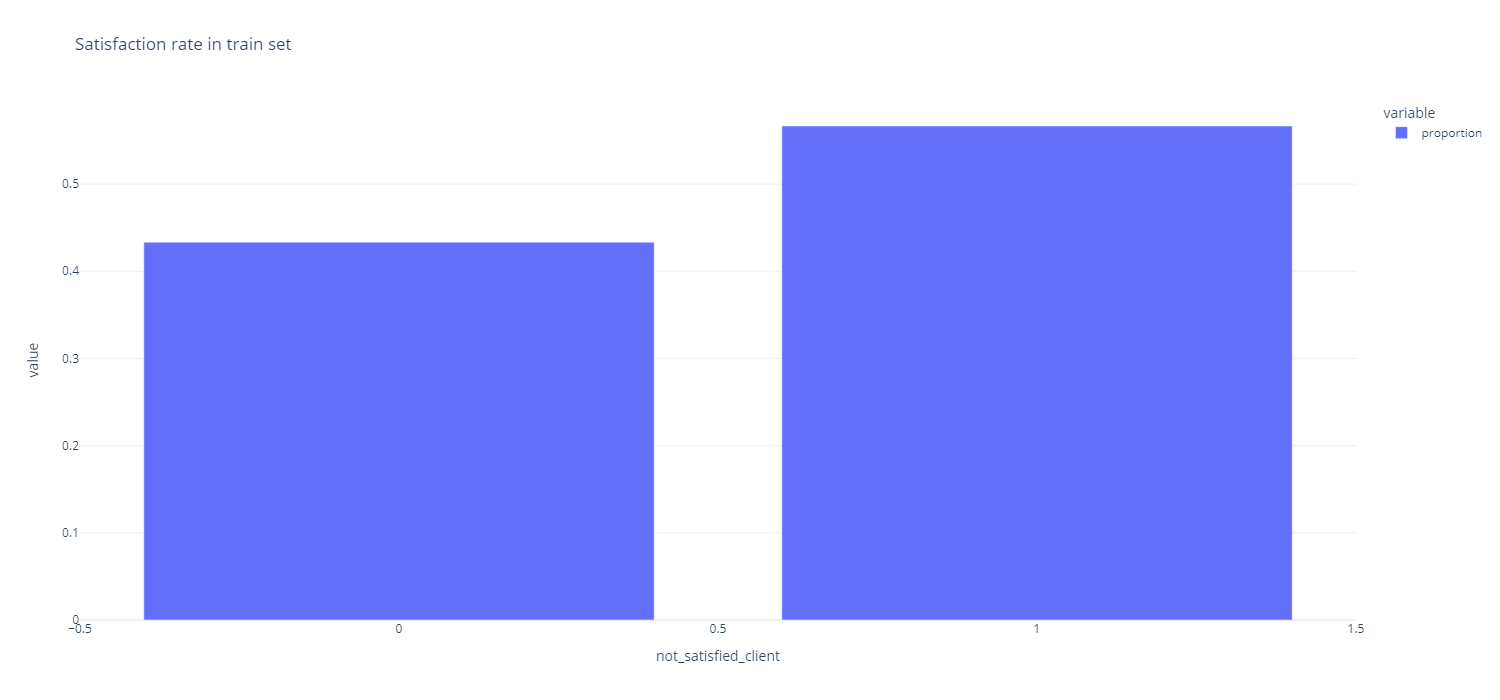

In [9]:
px.bar(df_train.not_satisfied_client.value_counts(normalize=True), title="Satisfaction rate in train set", )

In [10]:
from scipy.stats import ks_2samp, chi2_contingency

def calculate_ks_statistic(variable, target):
    """
    Calculate the KS statistic between a continuous variable and a binary target.

    Parameters:
    variable (array-like): Continuous variable.
    target (array-like): Binary target variable.

    Returns:
    float: KS statistic.
    """
    # Ensure inputs are numpy arrays
    variable = np.array(variable)
    target = np.array(target)

    # Split the variable data into two groups based on the target values
    group_0 = variable[target == 0]
    group_1 = variable[target == 1]

    # Perform the KS test
    ks_statistic, _ = ks_2samp(group_0, group_1)

    return ks_statistic

def calculate_chi2_statistic(variable, target):
    """
    Calculate the Chi-Square statistic between a categorical variable and a binary target.

    Parameters:
    variable (array-like): Categorical variable.
    target (array-like): Binary target variable.

    Returns:
    float: Chi-Square statistic.
    """
    # Ensure inputs are pandas Series
    variable = pd.Series(variable)
    target = pd.Series(target)

    # Create a contingency table
    contingency_table = pd.crosstab(variable, target)

    # Perform the Chi-Square test
    chi2_statistic, p_value, _, _ = chi2_contingency(contingency_table)

    return chi2_statistic

def calculate_total_variation_statistic(variable, target):
    """
    Calculate the Total Variation statistic between a categorical variable and a binary target.

    Parameters:
    variable (array-like): Categorical variable.
    target (array-like): Binary target variable.

    Returns:
    float: Chi-Square statistic.
    """
    # Ensure inputs are pandas Series
    variable = pd.Series(variable)
    target = pd.Series(target)

    # Create a contingency table
    contingency_table = pd.crosstab(variable, target, normalize='columns')

    # Perform the Total Variation test
    total_variation = 0.5 * abs(contingency_table.diff(axis=1).iloc[:, -1]).sum()

    return total_variation

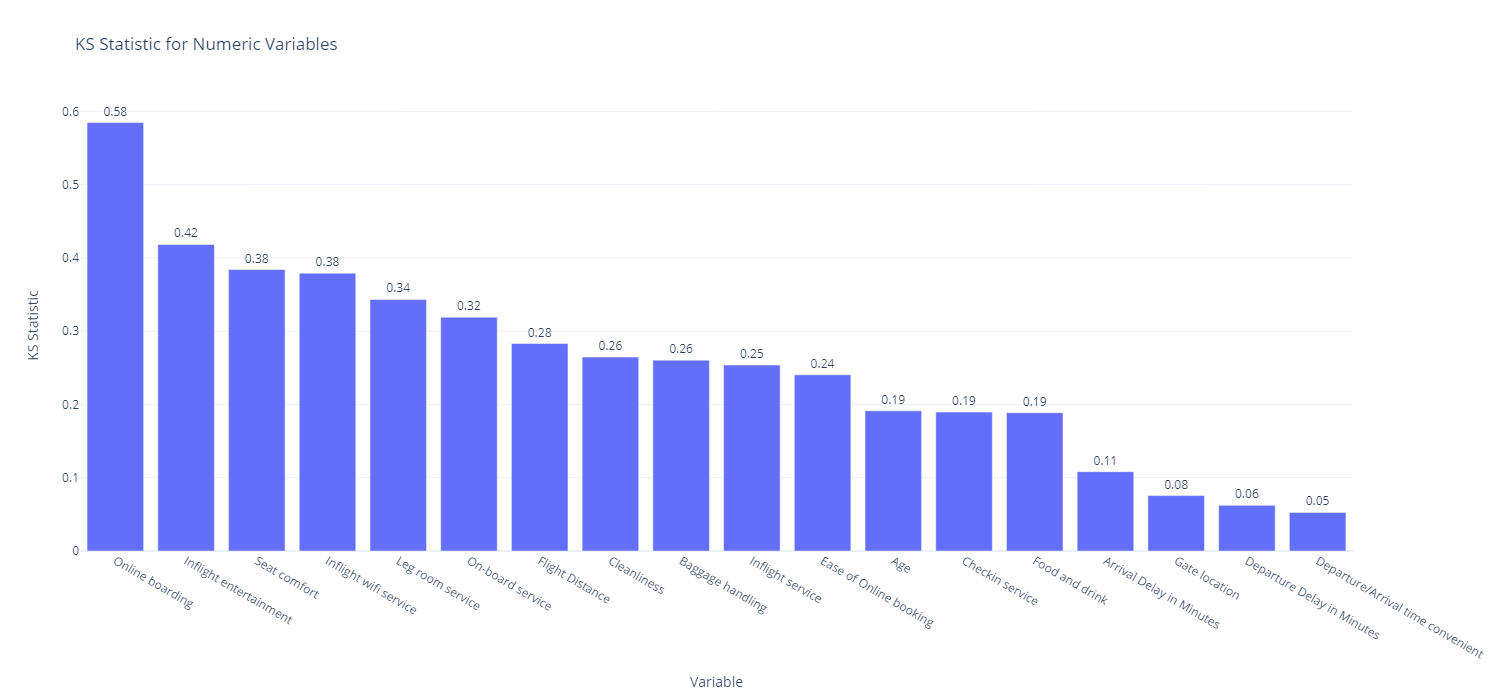

In [11]:
import numpy as np

ks_statistics = {}

target = df_train['not_satisfied_client']

for column in df_train.columns:
    if column != 'not_satisfied_client' and pd.api.types.is_numeric_dtype(df_train[column]):
        ks_stat = calculate_ks_statistic(df_train[column], target)
        ks_statistics[column] = ks_stat

# Convert the dictionary to a DataFrame for plotting
ks_df = pd.DataFrame(list(ks_statistics.items()), columns=['Variable', 'KS Statistic'])
ks_df = ks_df.sort_values(by='KS Statistic', ascending=False)

# Plot the bar plot using Plotly
fig = px.bar(
    ks_df,
    x='Variable',
    y='KS Statistic',
    title='KS Statistic for Numeric Variables',
    labels={'Variable': 'Numeric Variable', 'KS Statistic': 'KS Statistic'},
    text='KS Statistic'
)

# Update layout for better appearance
fig.update_layout(xaxis_title='Variable', yaxis_title='KS Statistic')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside', cliponaxis=False)

# Show the plot
fig.show()

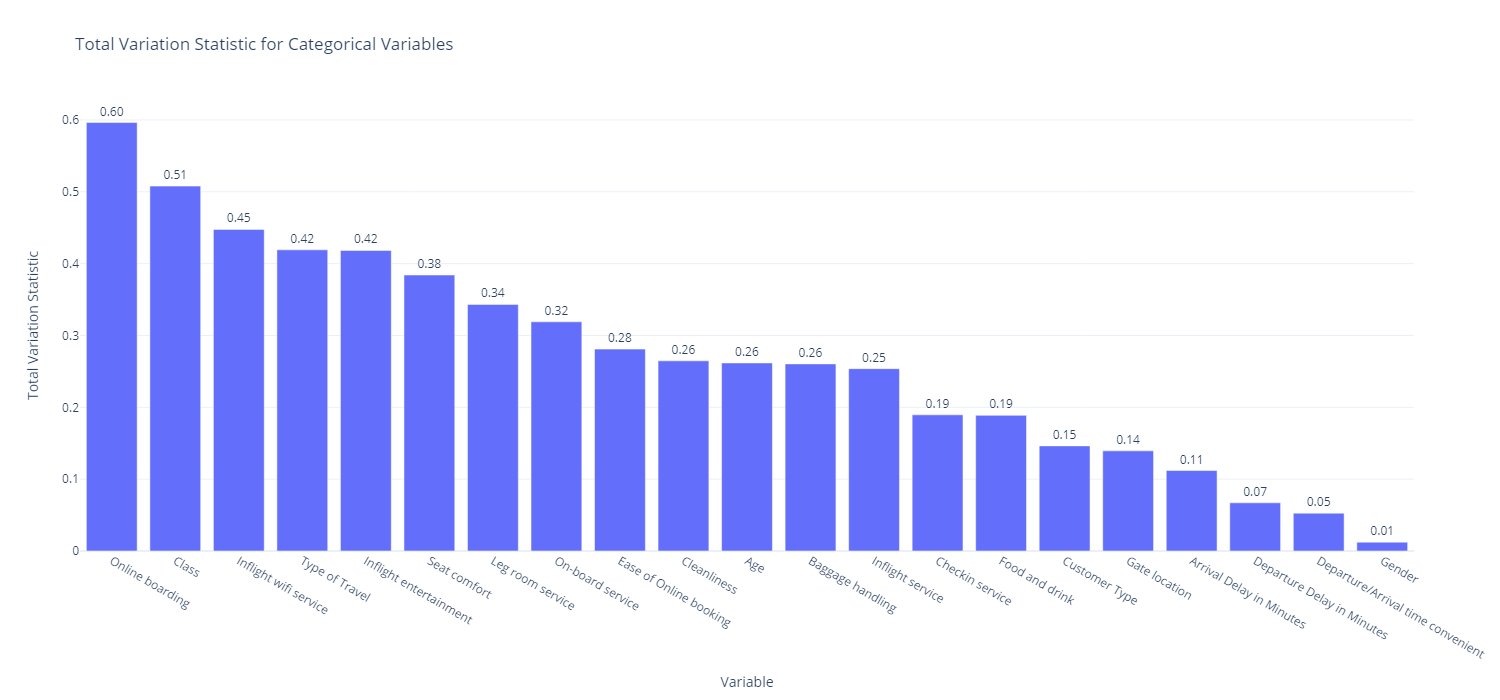

In [12]:
target = df_train['not_satisfied_client']

total_variation_statistics = {}
for column in df_train.columns:
    if column != 'not_satisfied_client' and column != 'Flight Distance':
        tv_stat = calculate_total_variation_statistic(df_train[column], target)
        total_variation_statistics[column] = tv_stat

# Convert the dictionary to a DataFrame for plotting
tv_df = pd.DataFrame(list(total_variation_statistics.items()), columns=['Variable', 'Total Variation Statistic'])
tv_df = tv_df.sort_values(by='Total Variation Statistic', ascending=False)

# Plot the bar plot using Plotly
fig = px.bar(
    tv_df,
    x='Variable',
    y='Total Variation Statistic',
    title='Total Variation Statistic for Categorical Variables',
    labels={'Variable': 'Categorical Variable', 'Total Variation Statistic': 'Total Variation Statistic'},
    text='Total Variation Statistic'
)

# Update layout for better appearance
fig.update_layout(xaxis_title='Variable', yaxis_title='Total Variation Statistic')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside', cliponaxis=False)

# Show the plot
fig.show()

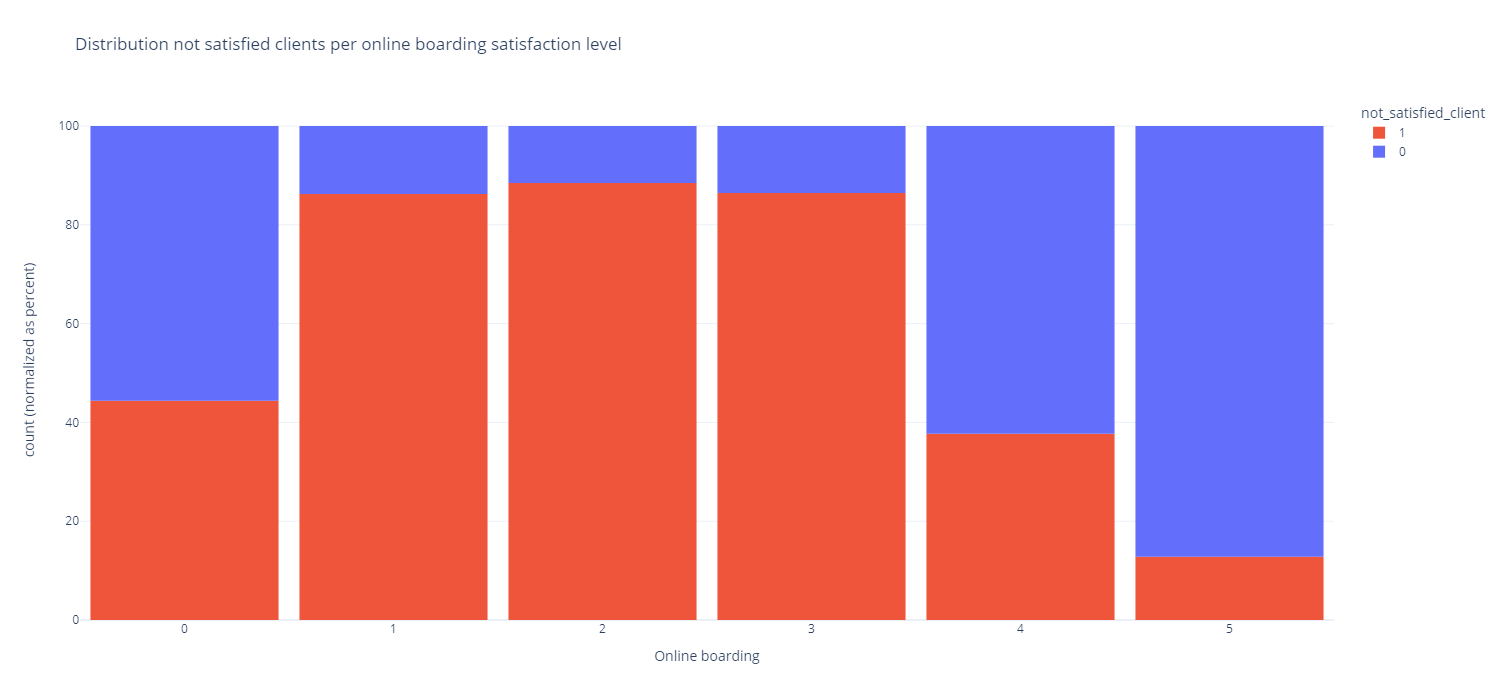

In [13]:
fig = px.histogram(df_train, x="Online boarding", color="not_satisfied_client", color_discrete_sequence = ["#EF553B", "#636EFA"],
                   title="Distribution not satisfied clients per online boarding satisfaction level", barnorm='percent')
fig.update_layout(bargap=0.1)
fig.show()

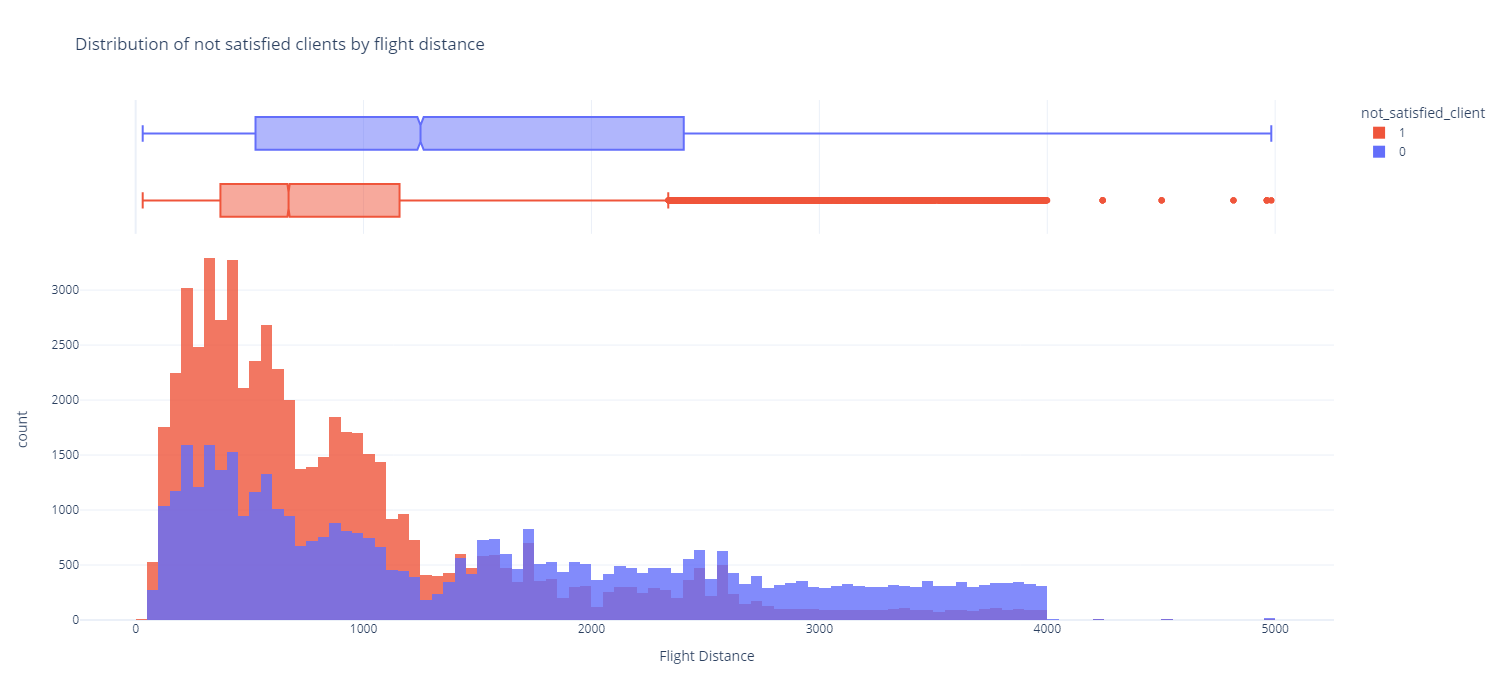

In [14]:
fig = px.histogram(df_train, x="Flight Distance", color="not_satisfied_client",
                 nbins=100, title="Distribution of not satisfied clients by flight distance",
                  color_discrete_sequence = ["#EF553B", "#636EFA"],
                  marginal="box", barmode='overlay', opacity=0.8 # or violin, rug
)
fig.show()

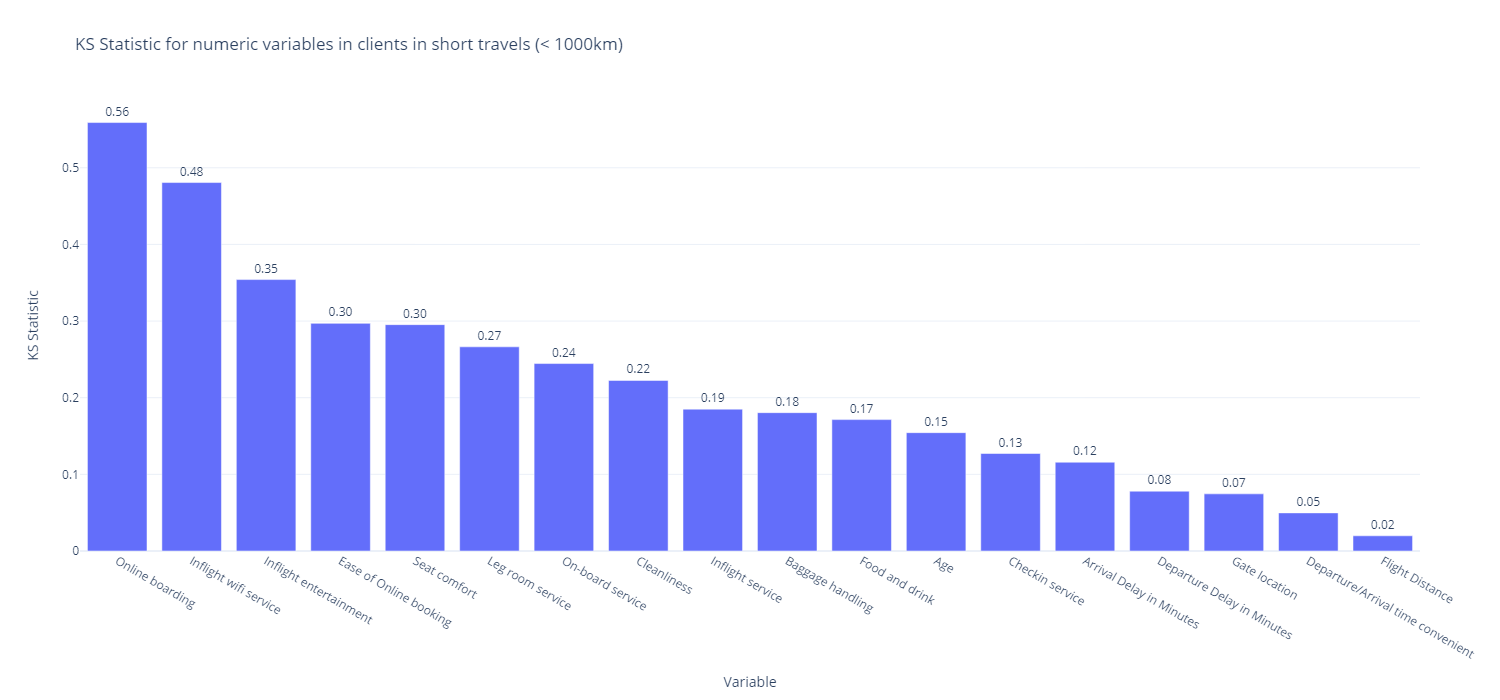

In [15]:
subset = df_train.loc[df_train['Flight Distance'] < 1000]
import numpy as np

ks_statistics = {}

target = subset['not_satisfied_client']

for column in subset.columns:
    if column != 'not_satisfied_client' and pd.api.types.is_numeric_dtype(subset[column]):
        ks_stat = calculate_ks_statistic(subset[column], target)
        ks_statistics[column] = ks_stat

# Convert the dictionary to a DataFrame for plotting
ks_df = pd.DataFrame(list(ks_statistics.items()), columns=['Variable', 'KS Statistic'])
ks_df = ks_df.sort_values(by='KS Statistic', ascending=False)

# Plot the bar plot using Plotly
fig = px.bar(
    ks_df,
    x='Variable',
    y='KS Statistic',
    title='KS Statistic for numeric variables in clients in short travels (< 1000km)',
    labels={'Variable': 'Numeric Variable', 'KS Statistic': 'KS Statistic'},
    text='KS Statistic'
)

# Update layout for better appearance
fig.update_layout(xaxis_title='Variable', yaxis_title='KS Statistic')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside', cliponaxis=False)

# Show the plot
fig.show()

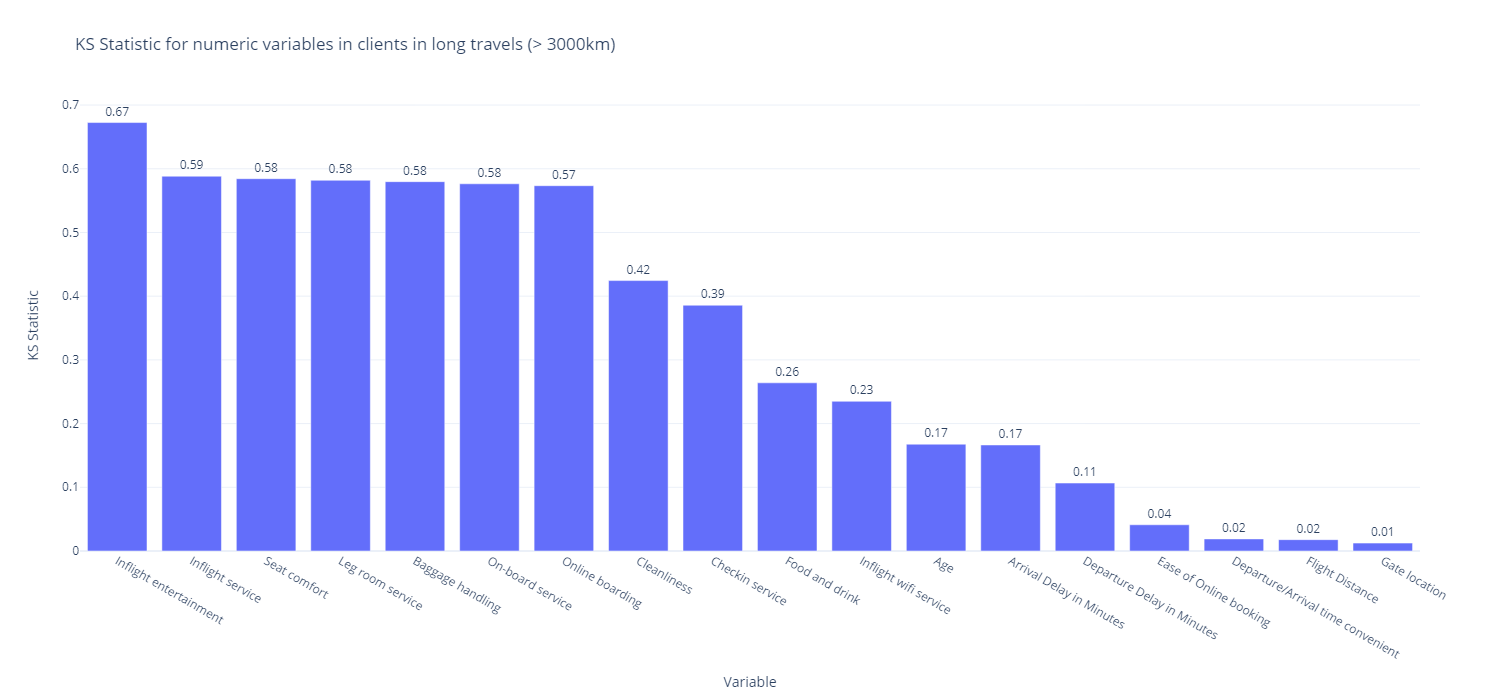

In [16]:
subset = df_train.loc[df_train['Flight Distance'] > 3000]
import numpy as np

ks_statistics = {}

target = subset['not_satisfied_client']

for column in subset.columns:
    if column != 'not_satisfied_client' and pd.api.types.is_numeric_dtype(subset[column]):
        ks_stat = calculate_ks_statistic(subset[column], target)
        ks_statistics[column] = ks_stat

# Convert the dictionary to a DataFrame for plotting
ks_df = pd.DataFrame(list(ks_statistics.items()), columns=['Variable', 'KS Statistic'])
ks_df = ks_df.sort_values(by='KS Statistic', ascending=False)

# Plot the bar plot using Plotly
fig = px.bar(
    ks_df,
    x='Variable',
    y='KS Statistic',
    title='KS Statistic for numeric variables in clients in long travels (> 3000km)',
    labels={'Variable': 'Numeric Variable', 'KS Statistic': 'KS Statistic'},
    text='KS Statistic'
)

# Update layout for better appearance
fig.update_layout(xaxis_title='Variable', yaxis_title='KS Statistic')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside', cliponaxis=False)

# Show the plot
fig.show()

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = [col for col in df_test.columns if col not in numerical_cols + ['id', 'not_satisfied_client']]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with median
    ('scaler', MinMaxScaler())  # Scale features to range [0, 1]
])

# Define the preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical features
])

# Combine both transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, object_cols)
    ],
    verbose_feature_names_out=False

)

# Example model (You can replace this with your own model)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
df_train_processed = pd.DataFrame(pipeline.fit_transform(df_train), columns = pipeline.get_feature_names_out())

In [18]:
df_test_processed = pd.DataFrame(pipeline.transform(df_test), columns = pipeline.get_feature_names_out())

In [19]:
from sklearn.model_selection import train_test_split

df_train_processed, df_val_processed = train_test_split(df_train_processed, test_size=0.2, random_state=13051905)

In [21]:
df_train_processed.to_csv("train_processed.csv", index=False)
df_val_processed.to_csv("val_processed.csv", index=False)
df_test_processed.to_csv("test_processed.csv", index=False)